In [1]:
import os
os.environ['XLA_PYTHON_PREALLOCATE'] = 'false'

In [2]:
!pip install -q grain


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [3]:
!pip install -q datasets


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [4]:
import jax
import jax.numpy as jnp
from flax import nnx
import optax

In [5]:
class VisionTransformer(nnx.Module):
    """ Implements the ViT model, inheriting from `flax.nnx.Module`.

    Args:
        num_classes (int): Number of classes in the classification. Defaults to 1000.
        in_channels (int): Number of input channels in the image (such as 3 for RGB). Defaults to 3.
        img_size (int): Input image size. Defaults to 224.
        patch_size (int): Size of the patches extracted from the image. Defaults to 16.
        num_layers (int): Number of transformer encoder layers. Defaults to 12.
        num_heads (int): Number of attention heads in each transformer layer. Defaults to 12.
        mlp_dim (int): Dimension of the hidden layers in the feed-forward/MLP block. Defaults to 3072.
        hidden_size (int): Dimensionality of the embedding vectors. Defaults to 3072.
        dropout_rate (int): Dropout rate (for regularization). Defaults to 0.1.
        rngs (flax.nnx.Rngs): A set of named `flax.nnx.RngStream` objects that generate a stream of JAX pseudo-random number generator (PRNG) keys. Defaults to `flax.nnx.Rngs(0)`.

    """
    def __init__(
        self,
        num_classes: int = 1000,
        in_channels: int = 3,
        img_size: int = 224,
        patch_size: int = 16,
        num_layers: int = 12,
        num_heads: int = 12,
        mlp_dim: int = 3072,
        hidden_size: int = 768,
        dropout_rate: float = 0.1,
        *,
        rngs: nnx.Rngs = nnx.Rngs(0),
    ):
        # Calculate the number of patches generated from the image.
        n_patches = (img_size // patch_size) ** 2
        # Patch embeddings:
        # - Extracts patches from the input image and maps them to embedding vectors
        #   using `flax.nnx.Conv` (convolutional layer).
        self.patch_embeddings = nnx.Conv(
            in_channels,
            hidden_size,
            kernel_size=(patch_size, patch_size),
            strides=(patch_size, patch_size),
            padding="VALID",
            use_bias=True,
            rngs=rngs,
        )

        # Positional embeddings (add information about image patch positions):
        # Set the truncated normal initializer (using `jax.nn.initializers.truncated_normal`).
        initializer = jax.nn.initializers.truncated_normal(stddev=0.02)
        # The learnable parameter for positional embeddings (using `flax.nnx.Param`).
        self.position_embeddings = nnx.Param(
            initializer(rngs.params(), (1, n_patches + 1, hidden_size), jnp.float32)
        ) # Shape `(1, n_patches +1, hidden_size`)
        # The dropout layer.
        self.dropout = nnx.Dropout(dropout_rate, rngs=rngs)

        # CLS token (a special token prepended to the sequence of patch embeddings)
        # using `flax.nnx.Param`.
        self.cls_token = nnx.Param(jnp.zeros((1, 1, hidden_size)))

        # Transformer encoder (a sequence of encoder blocks for feature extraction).
        # - Create multiple Transformer encoder blocks (with `nnx.Sequential`
        # and `TransformerEncoder(nnx.Module)` which is defined later).
        self.encoder = nnx.Sequential(*[
            TransformerEncoder(hidden_size, mlp_dim, num_heads, dropout_rate, rngs=rngs)
            for i in range(num_layers)
        ])
        # Layer normalization with `flax.nnx.LayerNorm`.
        self.final_norm = nnx.LayerNorm(hidden_size, rngs=rngs)

        # Classification head (maps the transformer encoder to class probabilities).
        self.classifier = nnx.Linear(hidden_size, num_classes, rngs=rngs)

    # The forward pass in the ViT model.
    def __call__(self, x: jax.Array) -> jax.Array:
        # Image patch embeddings.
        # Extract image patches and embed them.
        patches = self.patch_embeddings(x)
        # Get the batch size of image patches.
        batch_size = patches.shape[0]
        # Reshape the image patches.
        patches = patches.reshape(batch_size, -1, patches.shape[-1])

        # Replicate the CLS token for each image with `jax.numpy.tile`
        # by constructing an array by repeating `cls_token` along `[batch_size, 1, 1]` dimensions.
        cls_token = jnp.tile(self.cls_token, [batch_size, 1, 1])
        # Concatenate the CLS token and image patch embeddings.
        x = jnp.concat([cls_token, patches], axis=1)
        # Create embedded patches by adding positional embeddings to the concatenated CLS token and image patch embeddings.
        embeddings = x + self.position_embeddings
        # Apply the dropout layer to embedded patches.
        embeddings = self.dropout(embeddings)

        # Transformer encoder blocks.
        # Process the embedded patches through the transformer encoder layers.
        x = self.encoder(embeddings)
        # Apply layer normalization
        x = self.final_norm(x)

        # Extract the CLS token (first token), which represents the overall image embedding.
        x = x[:, 0]

        # Predict class probabilities based on the CLS token embedding.
        return self.classifier(x)


class TransformerEncoder(nnx.Module):
    """
    A single transformer encoder block in the ViT model, inheriting from `flax.nnx.Module`.

    Args:
        hidden_size (int): Input/output embedding dimensionality.
        mlp_dim (int): Dimension of the feed-forward/MLP block hidden layer.
        num_heads (int): Number of attention heads.
        dropout_rate (float): Dropout rate. Defaults to 0.0.
        rngs (flax.nnx.Rngs): A set of named `flax.nnx.RngStream` objects that generate a stream of JAX pseudo-random number generator (PRNG) keys. Defaults to `flax.nnx.Rngs(0)`.
    """
    def __init__(
        self,
        hidden_size: int,
        mlp_dim: int,
        num_heads: int,
        dropout_rate: float = 0.0,
        *,
        rngs: nnx.Rngs = nnx.Rngs(0),
    ) -> None:
        # First layer normalization using `flax.nnx.LayerNorm`
        # before we apply Multi-Head Attentn.
        self.norm1 = nnx.LayerNorm(hidden_size, rngs=rngs)
        # The Multi-Head Attention layer (using `flax.nnx.MultiHeadAttention`).
        self.attn = nnx.MultiHeadAttention(
            num_heads=num_heads,
            in_features=hidden_size,
            dropout_rate=dropout_rate,
            broadcast_dropout=False,
            decode=False,
            deterministic=False,
            rngs=rngs,
        )
        # Second layer normalization using `flax.nnx.LayerNorm`.
        self.norm2 = nnx.LayerNorm(hidden_size, rngs=rngs)

        # The MLP for point-wise feedforward (using `flax.nnx.Sequential`, `flax.nnx.Linear, flax.nnx.Dropout`)
        # with the GeLU activation function (`flax.nnx.gelu`).
        self.mlp = nnx.Sequential(
            nnx.Linear(hidden_size, mlp_dim, rngs=rngs),
            nnx.gelu,
            nnx.Dropout(dropout_rate, rngs=rngs),
            nnx.Linear(mlp_dim, hidden_size, rngs=rngs),
            nnx.Dropout(dropout_rate, rngs=rngs),
        )

    # The forward pass through the transformer encoder block.
    def __call__(self, x: jax.Array) -> jax.Array:
        # The Multi-Head Attention layer with layer normalization.
        x = x + self.attn(self.norm1(x))
        # The feed-forward network with layer normalization.
        x = x + self.mlp(self.norm2(x))
        return x

# Example usage for testing:
x = jnp.ones((4, 224, 224, 3))
model = VisionTransformer(num_classes=1000)
y = model(x)
print("Predictions shape: ", y.shape)

E0000 00:00:1751922959.685057      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:230


Predictions shape:  (4, 1000)


In [6]:
from transformers import FlaxViTForImageClassification

tf_model = FlaxViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.10/site-packages/torch_xla/__init__.py:251: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


In [7]:
# Copies weights from a TF ViT model to a Flax ViT model, reshaping layers
# to match the expected shapes in Flax.
def vit_inplace_copy_weights(*, src_model, dst_model):
    assert isinstance(src_model, FlaxViTForImageClassification)
    assert isinstance(dst_model, VisionTransformer)

    tf_model_params = src_model.params
    tf_model_params_fstate = nnx.traversals.flatten_mapping(tf_model_params)

    # Notice the use of `flax.nnx.state`.
    flax_model_params = nnx.state(dst_model, nnx.Param)
    flax_model_params_fstate = dict(flax_model_params.flat_state())

    # Mapping from Flax parameter names to TF parameter names.
    params_name_mapping = {
        ("cls_token",): ("vit", "embeddings", "cls_token"),
        ("position_embeddings",): ("vit", "embeddings", "position_embeddings"),
        **{
            ("patch_embeddings", x): ("vit", "embeddings", "patch_embeddings", "projection", x)
            for x in ["kernel", "bias"]
        },
        **{
            ("encoder", "layers", i, "attn", y, x): (
                "vit", "encoder", "layer", str(i), "attention", "attention", y, x
            )
            for x in ["kernel", "bias"]
            for y in ["key", "value", "query"]
            for i in range(12)
        },
        **{
            ("encoder", "layers", i, "attn", "out", x): (
                "vit", "encoder", "layer", str(i), "attention", "output", "dense", x
            )
            for x in ["kernel", "bias"]
            for i in range(12)
        },
        **{
            ("encoder", "layers", i, "mlp", "layers", y1, x): (
                "vit", "encoder", "layer", str(i), y2, "dense", x
            )
            for x in ["kernel", "bias"]
            for y1, y2 in [(0, "intermediate"), (3, "output")]
            for i in range(12)
        },
        **{
            ("encoder", "layers", i, y1, x): (
                "vit", "encoder", "layer", str(i), y2, x
            )
            for x in ["scale", "bias"]
            for y1, y2 in [("norm1", "layernorm_before"), ("norm2", "layernorm_after")]
            for i in range(12)
        },
        **{
            ("final_norm", x): ("vit", "layernorm", x)
            for x in ["scale", "bias"]
        },
        **{
            ("classifier", x): ("classifier", x)
            for x in ["kernel", "bias"]
        }
    }

    nonvisited = set(flax_model_params_fstate.keys())

    for key1, key2 in params_name_mapping.items():
        assert key1 in flax_model_params_fstate, key1
        assert key2 in tf_model_params_fstate, (key1, key2)

        nonvisited.remove(key1)

        src_value = tf_model_params_fstate[key2]
        if key2[-1] == "kernel" and key2[-2] in ("key", "value", "query"):
            shape = src_value.shape
            src_value = src_value.reshape((shape[0], 12, 64))

        if key2[-1] == "bias" and key2[-2] in ("key", "value", "query"):
            src_value = src_value.reshape((12, 64))

        if key2[-4:] == ("attention", "output", "dense", "kernel"):
            shape = src_value.shape
            src_value = src_value.reshape((12, 64, shape[-1]))

        dst_value = flax_model_params_fstate[key1]
        assert src_value.shape == dst_value.value.shape, (key2, src_value.shape, key1, dst_value.value.shape)
        dst_value.value = src_value.copy()
        assert dst_value.value.mean() == src_value.mean(), (dst_value.value, src_value.mean())

    assert len(nonvisited) == 0, nonvisited
    # Notice the use of `flax.nnx.update` and `flax.nnx.State`.
    nnx.update(dst_model, nnx.State.from_flat_path(flax_model_params_fstate))


vit_inplace_copy_weights(src_model=tf_model, dst_model=model)

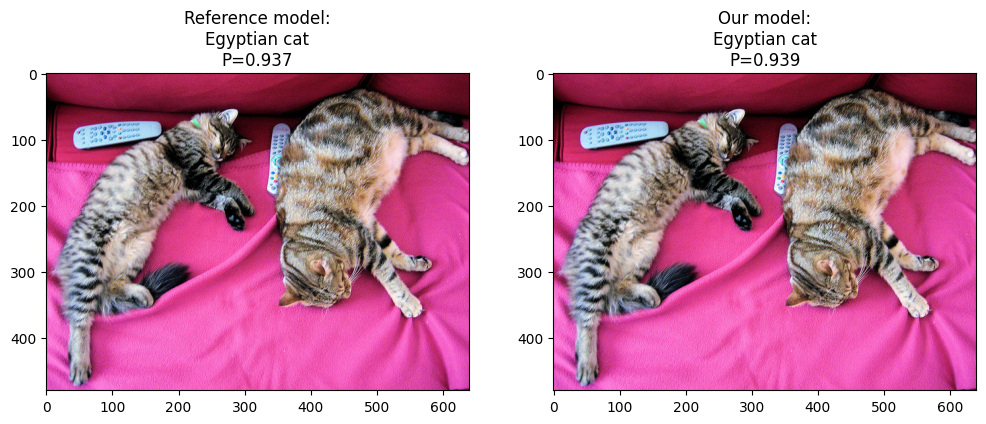

In [8]:
import matplotlib.pyplot as plt
from transformers import ViTImageProcessor
from PIL import Image
import requests

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')

inputs = processor(images=image, return_tensors="np")
outputs = tf_model(**inputs)
logits = outputs.logits


model.eval()
x = jnp.transpose(inputs["pixel_values"], axes=(0, 2, 3, 1))
output = model(x)

# Model predicts one of the 1000 ImageNet classes.
ref_class_idx = logits.argmax(-1).item()
pred_class_idx = output.argmax(-1).item()
assert jnp.abs(logits[0, :] - output[0, :]).max() < 0.1

fig, axs = plt.subplots(1, 2, figsize=(12, 8))
axs[0].set_title(
    f"Reference model:\n{tf_model.config.id2label[ref_class_idx]}\nP={nnx.softmax(logits, axis=-1)[0, ref_class_idx]:.3f}"
)
axs[0].imshow(image)
axs[1].set_title(
    f"Our model:\n{tf_model.config.id2label[pred_class_idx]}\nP={nnx.softmax(output, axis=-1)[0, pred_class_idx]:.3f}"
)
axs[1].imshow(image)

In [9]:
model.classifier = nnx.Linear(model.classifier.in_features, 100, rngs=nnx.Rngs(0))

x = jnp.ones((4, 224, 224, 3))
y = model(x)
print("Predictions shape: ", y.shape)

Predictions shape:  (4, 100)


In [10]:
from datasets import load_dataset

train_dataset = load_dataset("cifar100", split="train")
val_dataset = load_dataset("cifar100", split="test") # CIFAR-100 uses a 'test' split for validation

# CHANGE 3: The custom label mapping for Food101 is no longer needed and has been removed.
# CIFAR-100 labels are already in the 0-99 range.

print("Training dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))

Generating test split: 100%|██████████| 10000/10000 [00:00<00:00, 110730.17 examples/s]


Training dataset size: 50000
Validation dataset size: 10000


In [11]:
import matplotlib.pyplot as plt

def display_datapoints(*datapoints, tag="", names_map=None):
    num_samples = len(datapoints)

    fig, axs = plt.subplots(1, num_samples, figsize=(20, 10))
    for i, datapoint in enumerate(datapoints):
        # CHANGE 4: The key for the image data in CIFAR-100 is "img".
        if isinstance(datapoint, dict):
            img, label = datapoint["img"], datapoint["fine_label"]
        else:
            img, label = datapoint

        if hasattr(img, "dtype") and img.dtype in (np.float32, ):
            img = ((img - img.min()) / (img.max() - img.min()) * 255.0).astype(np.uint8)

        label_str = f" ({names_map[int(label)]})" if names_map is not None else ""
        axs[i].set_title(f"{tag}Label: {label}{label_str}")
        axs[i].imshow(img)

In [12]:
print(train_dataset.features)

{'img': Image(mode=None, decode=True, id=None), 'fine_label': ClassLabel(names=['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'cra', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'trac

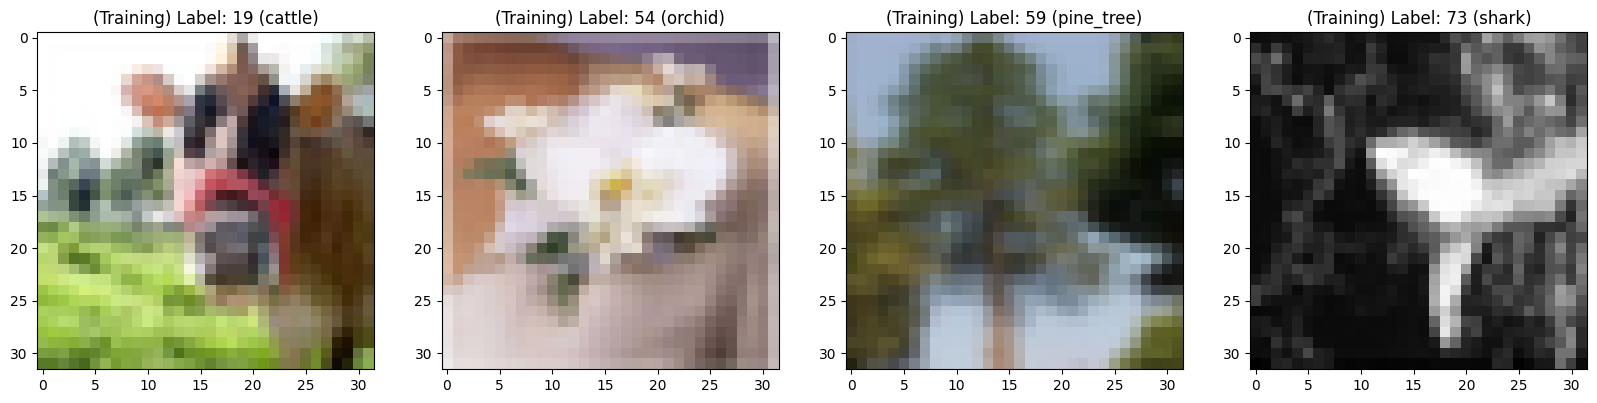

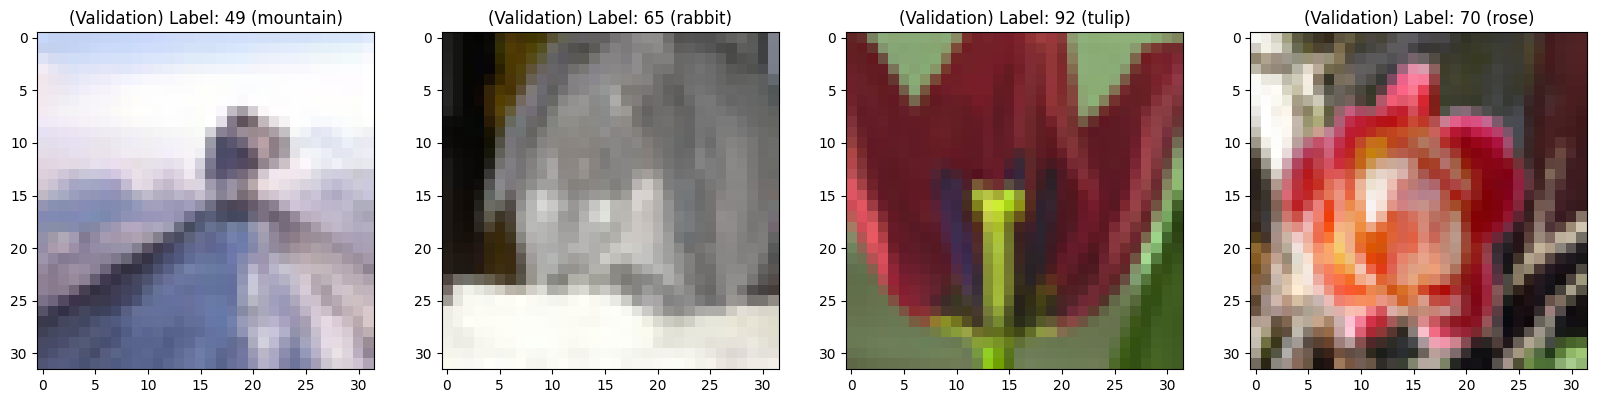

In [13]:
display_datapoints(
    train_dataset[0], train_dataset[1000], train_dataset[2000], train_dataset[3000],
    tag="(Training) ",
    # Use the default label names from the dataset features
    names_map=train_dataset.features["fine_label"].names
)

display_datapoints(
    val_dataset[0], val_dataset[1000], val_dataset[2000], val_dataset[-1],
    tag="(Validation) ",
    # Use the default label names from the dataset features
    names_map=val_dataset.features["fine_label"].names
)

In [14]:
import numpy as np
from torchvision.transforms import v2 as T

img_size = 224

def to_np_array(pil_image):
  return np.asarray(pil_image.convert("RGB"))

def normalize(image):
    # Image preprocessing matches the one of pretrained ViT
    mean = np.array([0.5, 0.5, 0.5], dtype=np.float32)
    std = np.array([0.5, 0.5, 0.5], dtype=np.float32)
    image = image.astype(np.float32) / 255.0
    return (image - mean) / std


tv_train_transforms = T.Compose([
    T.RandomResizedCrop((img_size, img_size), scale=(0.8, 1.0)), # Adjusted scale for smaller 32x32 images
    T.RandomHorizontalFlip(),
    T.ColorJitter(0.2, 0.2, 0.2),
    T.Lambda(to_np_array),
    T.Lambda(normalize),
])


tv_test_transforms = T.Compose([
    T.Resize((img_size, img_size)),
    T.Lambda(to_np_array),
    T.Lambda(normalize),
])

# CHANGE 5: The transform wrapper is simplified.
# It now correctly references the "img" feature and no longer needs to map labels.
def get_transform(fn):
    def wrapper(batch):
        # The feature name for the image in CIFAR-100 is "img"
        batch["img"] = [
            fn(pil_image) for pil_image in batch["img"]
        ]
        # The labels are already 0-99, so no mapping is needed.
        return batch
    return wrapper


train_transforms = get_transform(tv_train_transforms)
val_transforms = get_transform(tv_test_transforms)

train_dataset = train_dataset.with_transform(train_transforms)
val_dataset = val_dataset.with_transform(val_transforms)

In [15]:
import grain.python as grain


seed = 12
train_batch_size = 32
val_batch_size = 2 * train_batch_size


# Create an `grain.IndexSampler` with no sharding for single-device computations.
train_sampler = grain.IndexSampler(
    len(train_dataset),  # The total number of samples in the data source.
    shuffle=True,            # Shuffle the data to randomize the order.of samples
    seed=seed,               # Set a seed for reproducibility.
    shard_options=grain.NoSharding(),  # No sharding since this is a single-device setup.
    num_epochs=1,            # Iterate over the dataset for one epoch.
)

val_sampler = grain.IndexSampler(
    len(val_dataset),  # The total number of samples in the data source.
    shuffle=False,         # Do not shuffle the data.
    seed=seed,             # Set a seed for reproducibility.
    shard_options=grain.NoSharding(),  # No sharding since this is a single-device setup.
    num_epochs=1,          # Iterate over the dataset for one epoch.
)


train_loader = grain.DataLoader(
    data_source=train_dataset,
    sampler=train_sampler,                 # A sampler to determine how to access the data.
    worker_count=4,                        # Number of child processes launched to parallelize the transformations among.
    worker_buffer_size=2,                  # Count of output batches to produce in advance per worker.
    operations=[
        grain.Batch(train_batch_size, drop_remainder=True),
    ]
)

# Test (validation) dataset `grain.DataLoader`.
val_loader = grain.DataLoader(
    data_source=val_dataset,
    sampler=val_sampler,                   # A sampler to determine how to access the data.
    worker_count=4,                        # Number of child processes launched to parallelize the transformations among.
    worker_buffer_size=2,
    operations=[
        grain.Batch(val_batch_size),
    ]
)

In [16]:
train_batch = next(iter(train_loader))
val_batch = next(iter(val_loader))

In [17]:
print("Training batch info:", train_batch["img"].shape, train_batch["img"].dtype, train_batch["fine_label"].shape, train_batch["fine_label"].dtype)
print("Validation batch info:", val_batch["img"].shape, val_batch["img"].dtype, val_batch["fine_label"].shape, val_batch["fine_label"].dtype)

Training batch info: (32, 224, 224, 3) float32 (32,) int64
Validation batch info: (64, 224, 224, 3) float32 (64,) int64


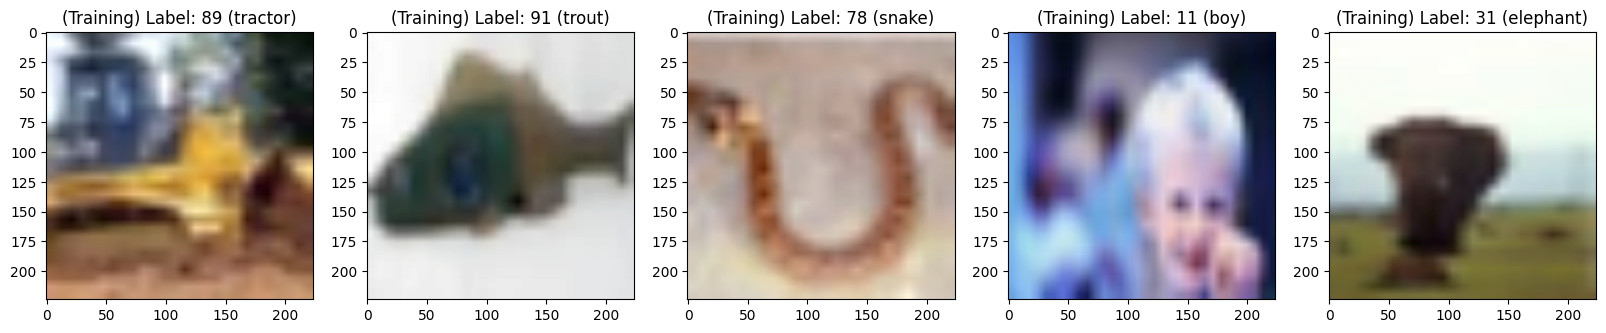

In [18]:
# CORRECTED CODE

display_datapoints(
    *[(train_batch["img"][i], train_batch["fine_label"][i]) for i in range(5)],
    tag="(Training) ",
    # FIX: Directly use the list of names. The label (e.g., 89) will be used as an index.
    names_map=train_dataset.features["fine_label"].names
)

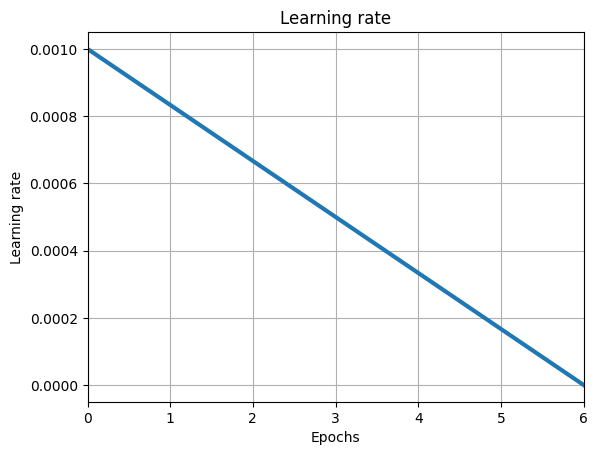

In [19]:
num_epochs = 6
learning_rate = 0.001
momentum = 0.8
total_steps = len(train_dataset) // train_batch_size

lr_schedule = optax.linear_schedule(learning_rate, 1e-6, num_epochs * total_steps)

iterate_subsample = np.linspace(0, num_epochs * total_steps, 100)
plt.plot(
    np.linspace(0, num_epochs, len(iterate_subsample)),
    [lr_schedule(i) for i in iterate_subsample],
    lw=3,
)
plt.title("Learning rate")
plt.xlabel("Epochs")
plt.ylabel("Learning rate")
plt.grid()
plt.xlim((0, num_epochs))
plt.show()


optimizer = nnx.Optimizer(model, optax.sgd(lr_schedule, momentum, nesterov=True))

In [20]:
def compute_losses_and_logits(model: nnx.Module, images: jax.Array, labels: jax.Array):
    logits = model(images)

    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=labels
    ).mean()
    return loss, logits

In [21]:
@nnx.jit
def train_step(
    model: nnx.Module, optimizer: nnx.Optimizer, batch: dict[str, np.ndarray]
):
    # Convert np.ndarray to jax.Array on GPU
    images = jnp.array(batch["img"])
    labels = jnp.array(batch["fine_label"], dtype=jnp.int32)

    grad_fn = nnx.value_and_grad(compute_losses_and_logits, has_aux=True)
    (loss, logits), grads = grad_fn(model, images, labels)

    optimizer.update(grads)  # In-place updates.

    return loss


@nnx.jit
def eval_step(
    model: nnx.Module, batch: dict[str, np.ndarray], eval_metrics: nnx.MultiMetric
):
    # Convert np.ndarray to jax.Array on GPU
    images = jnp.array(batch["img"])
    labels = jnp.array(batch["fine_label"], dtype=jnp.int32)
    loss, logits = compute_losses_and_logits(model, images, labels)

    eval_metrics.update(
        loss=loss,
        logits=logits,
        labels=labels,
    )

In [22]:
eval_metrics = nnx.MultiMetric(
    loss=nnx.metrics.Average('loss'),
    accuracy=nnx.metrics.Accuracy(),
)


train_metrics_history = {
    "train_loss": [],
}

eval_metrics_history = {
    "val_loss": [],
    "val_accuracy": [],
}

In [23]:
import tqdm


bar_format = "{desc}[{n_fmt}/{total_fmt}]{postfix} [{elapsed}<{remaining}]"


def train_one_epoch(epoch):
    model.train()  # Set model to the training mode: e.g. update batch statistics
    with tqdm.tqdm(
        desc=f"[train] epoch: {epoch}/{num_epochs}, ",
        total=total_steps,
        bar_format=bar_format,
        leave=True,
    ) as pbar:
        for batch in train_loader:
            loss = train_step(model, optimizer, batch)
            train_metrics_history["train_loss"].append(loss.item())
            pbar.set_postfix({"loss": loss.item()})
            pbar.update(1)


def evaluate_model(epoch):
    # Computes the metrics on the training and test sets after each training epoch.
    model.eval()  # Sets model to evaluation model: e.g. use stored batch statistics.

    eval_metrics.reset()  # Reset the eval metrics
    for val_batch in val_loader:
        eval_step(model, val_batch, eval_metrics)

    for metric, value in eval_metrics.compute().items():
        eval_metrics_history[f'val_{metric}'].append(value)

    print(f"[val] epoch: {epoch + 1}/{num_epochs}")
    print(f"- total loss: {eval_metrics_history['val_loss'][-1]:0.4f}")
    print(f"- Accuracy: {eval_metrics_history['val_accuracy'][-1]:0.4f}")

In [24]:
%%time

for epoch in range(num_epochs):
    train_one_epoch(epoch)
    evaluate_model(epoch)

[train] epoch: 0/6, [1560/1562], loss=0.47 [05:56<00:00] 


[val] epoch: 1/6
- total loss: 0.4612
- Accuracy: 0.8774


[train] epoch: 1/6, [1560/1562], loss=0.302 [05:29<00:00] 


[val] epoch: 2/6
- total loss: 0.3665
- Accuracy: 0.8983


[train] epoch: 2/6, [1560/1562], loss=0.272 [05:30<00:00] 


[val] epoch: 3/6
- total loss: 0.3435
- Accuracy: 0.9001


[train] epoch: 3/6, [1560/1562], loss=0.364 [05:31<00:00] 


[val] epoch: 4/6
- total loss: 0.3206
- Accuracy: 0.9075


[train] epoch: 4/6, [1560/1562], loss=0.238 [05:31<00:00] 


[val] epoch: 5/6
- total loss: 0.3083
- Accuracy: 0.9109


[train] epoch: 5/6, [1560/1562], loss=0.332 [05:23<00:00] 


[val] epoch: 6/6
- total loss: 0.3048
- Accuracy: 0.9115
CPU times: user 12min 24s, sys: 3min 15s, total: 15min 40s
Wall time: 35min 25s


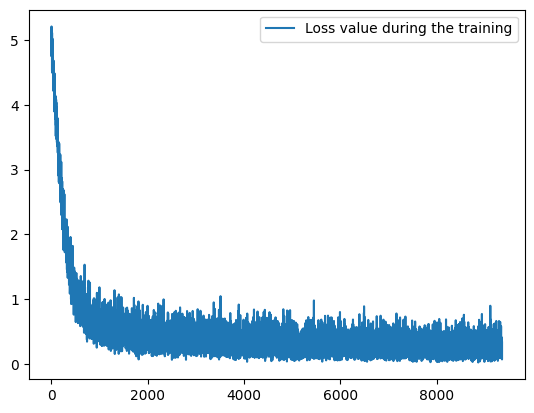

In [25]:
plt.plot(train_metrics_history["train_loss"], label="Loss value during the training")
plt.legend()

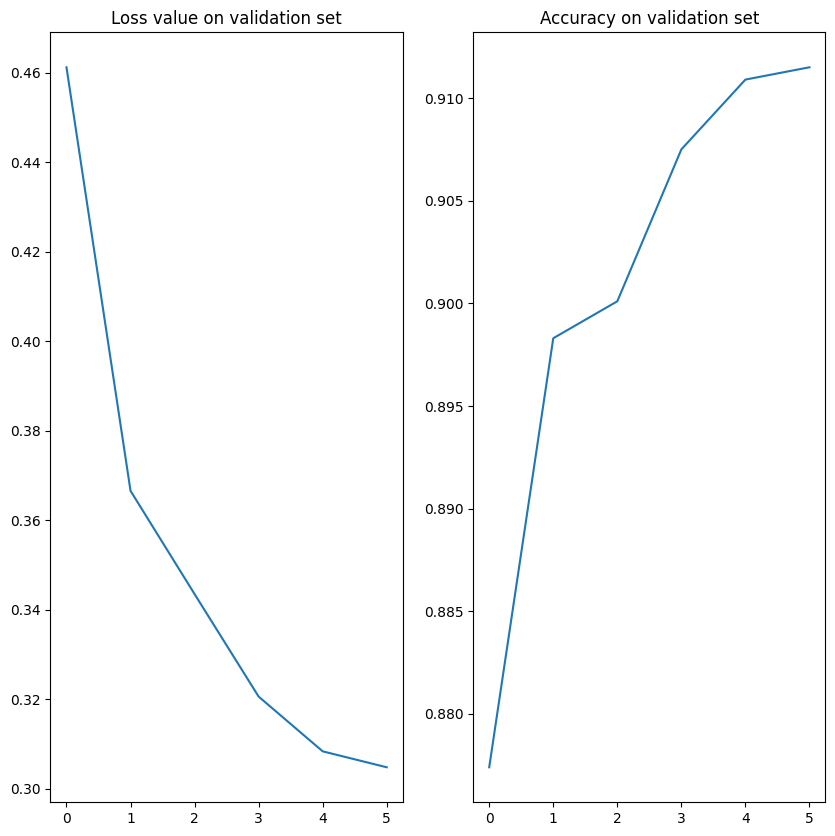

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].set_title("Loss value on validation set")
axs[0].plot(eval_metrics_history["val_loss"])
axs[1].set_title("Accuracy on validation set")
axs[1].plot(eval_metrics_history["val_accuracy"])

In [27]:
test_indices = [1, 250, 500, 750, 1000]

test_images = jnp.array([val_dataset[i]["img"] for i in test_indices])
expected_labels = [val_dataset[i]["fine_label"] for i in test_indices]

model.eval()
preds = model(test_images)

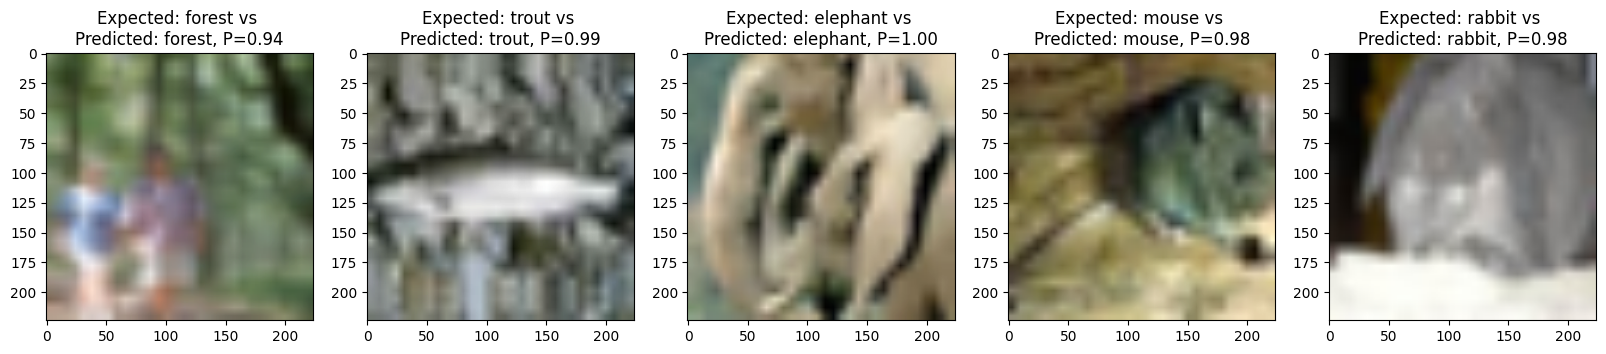

In [28]:
num_samples = len(test_indices)
names_map = train_dataset.features["fine_label"].names

probas = nnx.softmax(preds, axis=1)
pred_labels = probas.argmax(axis=1)


fig, axs = plt.subplots(1, num_samples, figsize=(20, 10))
for i in range(num_samples):
    img, expected_label = test_images[i], expected_labels[i]

    pred_label = pred_labels[i].item()
    proba = probas[i, pred_label].item()
    if img.dtype in (np.float32, ):
        img = ((img - img.min()) / (img.max() - img.min()) * 255.0).astype(np.uint8)

    expected_label_str = names_map[expected_label]
    pred_label_str = names_map[pred_label]
    axs[i].set_title(f"Expected: {expected_label_str} vs \nPredicted: {pred_label_str}, P={proba:.2f}")
    axs[i].imshow(img)